<a href="https://colab.research.google.com/github/julietamponti/tp2Datos-2C2021-/blob/main/6)_Consigna_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***Obtenga con spark los datos (de forma ya agregada) que le permitan realizar la siguiente visualización y realice la misma (3)***

Realizo la installacion de las librerias que utilizare en el desarrollo de la consulta.

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt update
!apt install openjdk-8-jdk-headless -qq
!pip install --upgrade pandas
#!apt install default-jre
#!apt install default-jdk
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64/"

     |████████████████████████████████| 281.3 MB 29 kB/s 
     |████████████████████████████████| 198 kB 57.2 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=52cd570f6d337683542be790ec0266b26bc0dc5bbe1953db59b55fc2d0136f15
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hi

In [ ]:
!pip install pyarrow

Importo las librerias.

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext
from pyspark.sql import SQLContext
import pandas as pd 

In [ ]:
import pyarrow

Creo el sparkSession.

In [ ]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

Accedo a mi drive, para poder acceder al archivo.

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')
sqlContext = SQLContext(sc)

Mounted at /content/gdrive


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


Leo el archivo.

In [ ]:
logs = sqlContext.read.parquet('gdrive/My Drive/TP2 - Datos/logs.parquet')

In [ ]:
rddLogs = logs.rdd

Limpio el archivo (de los None) y filtro segun las acciones que me interesa trabajar.

In [ ]:
rddAc = rddLogs.filter(lambda x: x.contributor_username != None and x.action != None and ( x.action == 'autocreate' or x.action == 'block' or x.action == 'create' or x.action == 'delete' or x.action == 'move'))

Con un .map le doy el formato que me interesa al rdd.

In [ ]:
rddAc = rddAc.map(lambda x: ((x.contributor_username,x.action),1))

Realizo el calculo para ver cuantas veces hace cada usuario, cada accion.

In [ ]:
rddAc = rddAc.reduceByKey(lambda x,y:x+y)

In [ ]:
rddAc.take(2)

[(('Ecemaml', 'delete'), 6973), (('Salvemos ballenas', 'move'), 2)]

Ahora generare un rdd que contendra (key= nombre del usuario, value = (cada accion, cantidad de veces que la realizo))

In [ ]:
rddTuplas = rddAc.map(lambda x: (x[0][0], (x[0][1], x[1])))

In [ ]:
rddTuplas.take(2)

[('Ecemaml', ('delete', 6973)), ('Salvemos ballenas', ('move', 2))]

Cree una funcion para crear una unica tupla como valor de cada usuario, que me indique dependiendo la posicion de la tupla, de que tipo de acciones hizo y cuantas.

In [ ]:
def tuplear(x):
    # (user,(#autocreate, #block, #create, #delete, #move))
    tupla = [0,0,0,0,0]
    if x[0] == 'autocreate':
      tupla[0] = x[1]
      return tuple(tupla)
    elif x[0] == 'block':
      tupla[1] = x[1]
      return tuple(tupla)
    elif x[0] == 'create':
      tupla[2] = x[1]
      return tuple(tupla)
    elif x[0] == 'delete':
      tupla[3] = x[1]
      return tuple(tupla)
    else:
      tupla[4] = x[1]
      return tuple(tupla)


In [ ]:
rddTuplas = rddTuplas.map(lambda x: (x[0],tuplear(x[1])))

In [ ]:
rddTuplas.take(2)

[('Ecemaml', (0, 0, 0, 6973, 0)), ('Salvemos ballenas', (0, 0, 0, 0, 2))]

Calculo la cantidad final de actividades por cada usario, de cualquiera de los 5 tipos.

In [ ]:
rddTuplas = rddTuplas.reduceByKey(lambda x,y:(x[0]+y[0],x[1]+y[1],x[2]+y[2],x[3]+y[3],x[4]+y[4])).cache()

In [ ]:
rddTuplas.take(2)

[('Andrae~eswiki', (0, 0, 1, 0, 0)), ('Carinabumer', (0, 0, 1, 0, 0))]

La formula que debo calcular para obtener el valor de las correlaciones es la siguiente: 
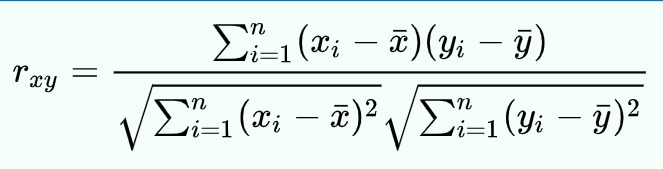

Calculo el total de cantidad de veces que se hizo cada actividad, y la cantidad de usuarios que realizaron actividades. Para luego poder calcular los promedios (x raya e y raya) para la formula necesaria.

In [ ]:
totalActUser = rddTuplas.map(lambda x: (x[1],1)).reduce(lambda x,y:((x[0][0]+y[0][0],x[0][1]+y[0][1],x[0][2]+y[0][2],x[0][3]+y[0][3],x[0][4]+y[0][4]), x[1]+y[1]))

In [ ]:
totalActUser

((1368824, 342252, 5940612, 2396290, 860766), 6114059)

Calculo los promedios.

In [ ]:
promAct = (totalActUser[0][0]/totalActUser[1],totalActUser[0][1]/totalActUser[1],totalActUser[0][2]/totalActUser[1],totalActUser[0][3]/totalActUser[1],totalActUser[0][3]/totalActUser[1])

Por cuestion de mejor legibilidad, almacene el valor de cada promedio en variables distintas.

In [ ]:
promedio_autocreate = promAct[0]

In [ ]:
promedio_block = promAct[1]

In [ ]:
promedio_create = promAct[2]

In [ ]:
promedio_delete =  promAct[3]

In [ ]:
promedio_move = promAct[4]

Genero un rdd "x_menos_x_raya", que vale para los terminos de la funcion mostrada anterior mente. Tanto para x_menos_x_raya como para y_menos_y_raya. Lo que se realiza en este punto, es calcular la diferencia, entre la cantidad de veces que cada usuario realizo cada actividad - el promedio por usuario de que esa actividad sea realizada. 

In [ ]:
x_menos_x_raya = rddTuplas.map(lambda x: (x[0], x[1][0] - promedio_autocreate, x[1][1]-promedio_block, x[1][2]-promedio_create,x[1][3]-promedio_delete,x[1][4]-promedio_move)).cache()

In [ ]:
x_menos_x_raya.take(2)

[('Andrae~eswiki',
  -0.2238813855083832,
  -0.055977870020554266,
  0.02836855188999643,
  -0.3919311213712527,
  -0.3919311213712527),
 ('Carinabumer',
  -0.2238813855083832,
  -0.055977870020554266,
  0.02836855188999643,
  -0.3919311213712527,
  -0.3919311213712527)]

Importo la libreria numpy, para realizar operaciones aritmeticas.

In [ ]:
import numpy as np

Indices:


1.   Autocreate
2.   Block
3.   Create
4.   Delete
5.   Move




Defino la funcion "correlaciones", que recibe dos indices, y lo que realiza es, aplicando la funcion que mostre anteriormente, calcular la correlacion entre esas dos acciones (correspondientes cada una a los indices indicados respectivamente).

In [ ]:
def correlaciones(indice1, indice2):
    numerador = x_menos_x_raya.map(lambda x: (x[indice1]*x[indice2])).reduce(lambda x,y: x+y)
    denominador1 = np.sqrt(x_menos_x_raya.map(lambda x: (x[indice1]**2)).reduce(lambda x,y:x+y))
    denominador2 = np.sqrt(x_menos_x_raya.map(lambda x: (x[indice2]**2)).reduce(lambda x,y:x+y))
    return (numerador/(denominador1*denominador2))

Genero la matriz de correlaciones entre todas las actividades.

In [ ]:
matriz = [[correlaciones(1,1),correlaciones(1,2),correlaciones(1,3),correlaciones(1,4),correlaciones(1,5)],[correlaciones(2,1),correlaciones(2,2),correlaciones(2,3),correlaciones(2,4),correlaciones(2,5)],[correlaciones(3,1),correlaciones(3,2),correlaciones(3,3),correlaciones(3,4),correlaciones(3,5)],[correlaciones(4,1),correlaciones(4,2),correlaciones(4,3),correlaciones(4,4),correlaciones(4,5)],[correlaciones(5,1),correlaciones(5,2),correlaciones(5,3),correlaciones(5,4),correlaciones(5,5)]]

In [ ]:
matriz

[[1.0,
  -0.0011732505989098467,
  -0.005115620753970479,
  -0.0013987147576500862,
  0.0002769501605177375],
 [-0.0011732505989098467,
  1.0,
  0.04889544034113139,
  0.694869107440536,
  0.052623832613818936],
 [-0.005115620753970479,
  0.04889544034113139,
  1.0,
  0.07016330061647112,
  0.013696697302446149],
 [-0.0013987147576500862,
  0.694869107440536,
  0.07016330061647112,
  1.0000000000000002,
  0.08380323592245703],
 [0.0002769501605177375,
  0.052623832613818936,
  0.013696697302446149,
  0.08380323592245703,
  1.0000000000000002]]

Importo las librerias para realizar la visualización.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

([<matplotlib.axis.YTick at 0x7f7096576c50>,
 [Text(0, 0.5, 'autocreate'),
  Text(0, 1.5, 'block'),
  Text(0, 2.5, 'create'),
  Text(0, 3.5, 'delete'),
  Text(0, 4.5, 'move')])

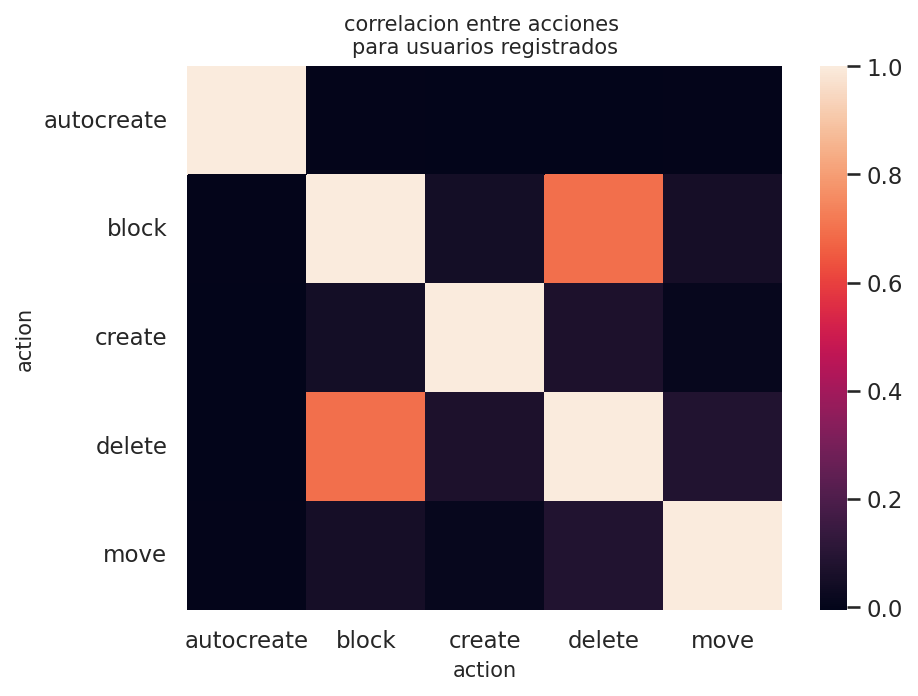

In [ ]:
sns.set(rc={"figure.dpi":150})
sns.set(rc = {'figure.figsize':(6.4, 4.8)})
aa = sns.heatmap(matriz)
aa.set_title('correlacion entre acciones \npara usuarios registrados',size =10)
aa.set_xlabel("action", fontsize = 10)
aa.set_ylabel("action", fontsize = 10)
plt.xticks([0.5,1.5,2.5,3.5,4.5], ['autocreate','block','create','delete','move'])
plt.yticks([0.5,1.5,2.5,3.5,4.5], ['autocreate','block','create','delete','move'],rotation=0)